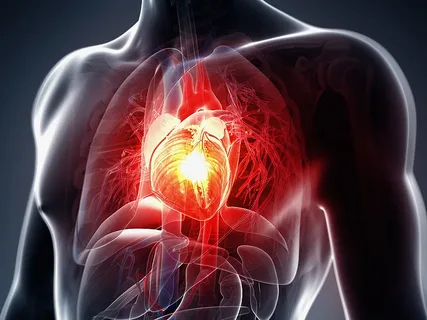

In this task, we have 14 variables: Target and many different features that reflect the health of the heart and body (angina, blood sugar, age, blood cholesterol, blood pressure, etc.). We have no missing values and only 1 duplicate, which we will immediately delete. Let's do a visual analysis right away. All conclusions are below

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
df=pd.read_csv('../input/heart-attack-analysis-prediction-dataset/heart.csv')
df_o2=pd.read_csv('../input/heart-attack-analysis-prediction-dataset/o2Saturation.csv')

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.isna().sum()

In [ ]:
df[df.duplicated()]


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.describe()

In [ ]:
sns.countplot(df['slp'])

In [ ]:
sns.countplot(df['caa'])

In [ ]:
sns.countplot(df['slp'])

In [ ]:
sns.countplot(df['exng'])

In [ ]:
sns.countplot(df['thall'])

In [ ]:
sns.displot(df['thalachh'])

In [ ]:
sns.countplot(df['fbs'])

In [ ]:
sns.countplot(df['restecg'])

In [ ]:
sns.distplot(df['chol'])

In [ ]:
sns.distplot(df['trtbps'])

In [ ]:
sns.distplot(df['age'])

In [ ]:
sns.countplot(df['sex'],hue=df['output'])

In [ ]:
sns.countplot(df['cp'])

In [ ]:
sns.countplot(df['exng'],hue=df['output'])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (15, 8))
sns.scatterplot(data=df,x='thalachh',y='chol' ,hue='output')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (15, 8))
sns.scatterplot(data=df,x='thalachh',y='age' ,hue='output')

In [ ]:
labels=['less chance of heart attack','more chance of heart attack']
colors = ["cyan","red"]
plt.pie(df['output'].value_counts(),labels=labels,colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=140) 
plt.show()

In [ ]:
sns.countplot(df['cp'],hue=df['output'])

In [ ]:
plt.figure(figsize=(15,8))
sns.displot(df, x="trtbps", hue="output", element="step")

In [ ]:
plt.figure(figsize=(15,8))
sns.displot(df, x="chol", hue="output", element="step")

In [ ]:
plt.figure(figsize=(15,8))
sns.displot(df, x="thalachh", hue="output", element="step")

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(df["slp"], hue=df["output"])

In [ ]:
plt.figure(figsize=(15,8))
sns.swarmplot(x=df['caa'],y=df['age'],hue=df['output'])

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(df['restecg'],hue=df['output'])

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True)

In [ ]:
summary_df = df[['exng','caa','cp','restecg','fbs','sex','output']]
summary = pd.concat([pd.crosstab(summary_df[x], summary_df.output) for x in summary_df.columns[:-1]], keys=summary_df.columns[:-1])
summary

Based on the visual analysis, we can immediately see the distribution of our data, the relationships. However, it is worth noting that there is a relationship between age and the number of large vessels, and the actual heart problems. You can also see that pressure also plays an important role (the higher the pressure, the worse, of course). It can also be seen that if a patient's ECG shows ST wave abnormality, this significantly increases the risks. You can also see that there is a tendency to increase blood pressure with age and cholesterol levels

In [ ]:
X=df.drop('output',axis=1)
y=df['output']

In [ ]:
from sklearn import preprocessing
norm = preprocessing.StandardScaler()
ndf=norm.fit_transform(X)
X = pd.DataFrame(ndf, index=X.index, columns=X.columns)
X.head(10)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

Let's start building models. I chose 2 models: LightGBM and Catboost. I focused primarily on the interpretability of the results. For this purpose, in addition to various metrics, graphs of the significance of the features were constructed. The importance of signs in medical tasks is important for early identification of patients. The idea is simple: Randomly rearrange or shuffle one column in the validation dataset set, leaving all the other columns intact. A feature is considered "important" if the model's accuracy drops and its change causes an increase in errors. On the other hand, a feature is considered "unimportant" if the shuffling of its values does not affect the accuracy of the model.

In [ ]:
import lightgbm as lgb
clf = lgb.LGBMClassifier(class_weight='balanced',drop_rate=0.8, min_data_in_leaf=10, 
                                 n_estimators=250,min_sum_hessian_in_leaf=5,importance_type='gain',
                         learning_rate=0.09,bagging_fraction = 0.9,objective='binary',
                         boosting_type='goss',metric='auc',colsample_bytree=0.8,feature_fraction = 0.1,
                         reg_alpha = 5,reg_lambda = 5,max_depth = 8,
                                 min_child_samples = 55,min_child_weight = 5.0,min_split_gain = 0.01,
                         num_leaves = 70,subsample = 1,random_state=42)  
clf.fit(X_train,y_train)

In [ ]:
y_predict=clf.predict(X_test)
print(classification_report(y_test, y_predict))

In [ ]:
print(roc_auc_score(y_test,y_predict))
print(plot_confusion_matrix(clf,X_test,y_test))

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(15, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [ ]:
from catboost import CatBoostClassifier
catboost_params = {'loss_function' : 'CrossEntropy',
            'iterations': 100,
            'depth': 5,
            'learning_rate': 0.01,
            'eval_metric': 'AUC',
            'random_seed': 42,
            'l2_leaf_reg': 50.0,
            'bagging_temperature': 0.5,
            'allow_writing_files': True, 'border_count':50
        }
model = CatBoostClassifier(**catboost_params)
model.fit(X_train, y_train,verbose=False)

In [ ]:
y_predict=model.predict(X_test)
print(classification_report(y_test, y_predict))

In [ ]:
print(roc_auc_score(y_test,y_predict))
print(plot_confusion_matrix(model,X_test,y_test))

In [ ]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(15,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [ ]:
plot_feature_importance(model.get_feature_importance(),X_train.columns,'CATBOOST')

Both models showed their good side. Personally, I would prefer the CatBoost model, as it better identifies sick people. It is also worth noting what features are important for a particular model. For the LightGBM model, these are ca, old peak, cholesterol, and cp. For CatBoost, it's already thall, cap, and sternum pain. Upvote :)